In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib
!pip install supervision

# Descargar el modelo SAM (vit_h)
!wget -O /content/sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jrc2zrrj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jrc2zrrj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=0961174b2be66f0b82204629a66e829d525c068755145b2d702bb528592f9648
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlhli9lx/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.2 MB/s eta 0:00:00
--2025-05-19 18:32:45--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.102, 108.157.254.15, 108

In [ ]:
from segment_anything import sam_model_registry, SamPredictor
import torch

checkpoint_path = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device='cuda')  # Usa GPU si está disponible

predictor = SamPredictor(sam)


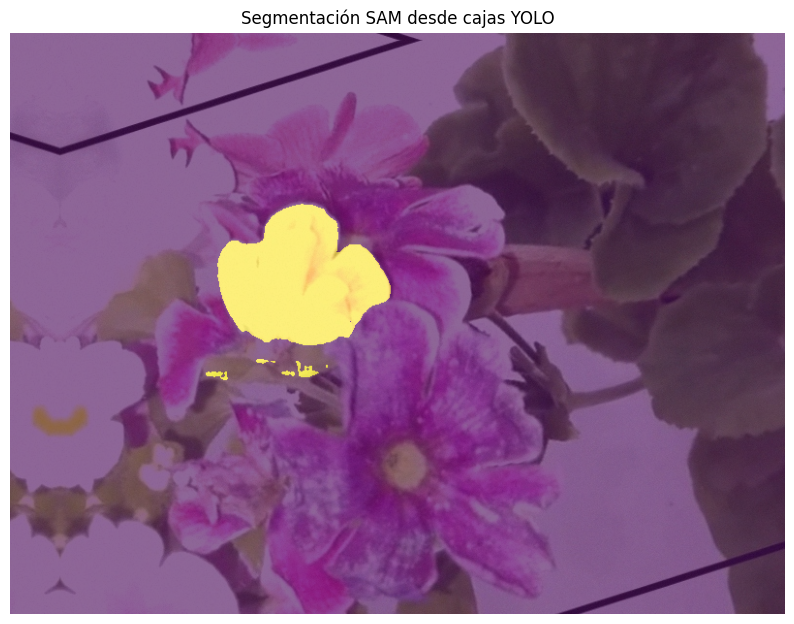

In [ ]:
import os
import cv2
import numpy as np
import torch
from segment_anything import SamPredictor
import matplotlib.pyplot as plt

# Ruta de la imagen y etiqueta YOLO
image_name = "Flor Primavera 113.jpg"


image_folder = "/content/drive/MyDrive/flores_anotation/yolo_dataset/images/val"
label_folder = "/content/drive/MyDrive/flores_anotation/yolo_dataset/labels/val"  # ✅ corregida

image_path = os.path.join(image_folder, image_name)
label_path = os.path.join(label_folder, image_name.replace(".jpg", ".txt"))

# Verificar existencia
assert os.path.exists(image_path), f"Imagen no encontrada: {image_path}"
assert os.path.exists(label_path), f"Etiqueta YOLO no encontrada: {label_path}"

# Cargar imagen y preparar para SAM
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Enviar imagen a predictor SAM
predictor.set_image(image_rgb)
height, width = image_rgb.shape[:2]

# Leer cajas YOLO y convertir a formato SAM
boxes = []
with open(label_path, 'r') as f:
    for line in f.readlines():
        class_id, x_center, y_center, w, h = map(float, line.strip().split())
        x_min = int((x_center - w / 2) * width)
        y_min = int((y_center - h / 2) * height)
        x_max = int((x_center + w / 2) * width)
        y_max = int((y_center + h / 2) * height)
        boxes.append([x_min, y_min, x_max, y_max])
boxes_np = np.array(boxes)

# Generar segmentaciones SAM desde cajas
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=torch.tensor(boxes_np, device=predictor.device),
    multimask_output=False,
)

# Visualizar máscaras
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
for mask in masks:
    #plt.imshow(mask.cpu().numpy(), alpha=0.6)
    plt.imshow(mask.squeeze(0).cpu().numpy(), alpha=0.6)

plt.title("Segmentación SAM desde cajas YOLO")
plt.axis("off")
plt.show()


In [ ]:
height, width = image_rgb.shape[:2]

boxes = []
with open(label_path, 'r') as f:
    for line in f.readlines():
        class_id, x_center, y_center, w, h = map(float, line.strip().split())
        x_min = int((x_center - w / 2) * width)
        y_min = int((y_center - h / 2) * height)
        x_max = int((x_center + w / 2) * width)
        y_max = int((y_center + h / 2) * height)
        boxes.append([x_min, y_min, x_max, y_max])
boxes_np = np.array(boxes)


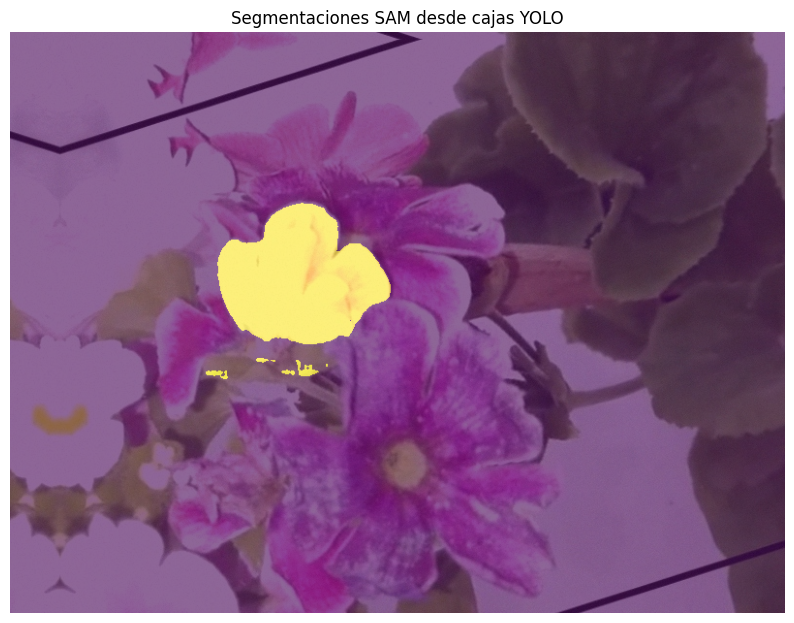

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
for mask in masks:
    #plt.imshow(mask.cpu().numpy(), alpha=0.6)  # Superponer máscaras
    plt.imshow(mask.squeeze(0).cpu().numpy(), alpha=0.6)

plt.axis("off")
plt.title("Segmentaciones SAM desde cajas YOLO")
plt.show()


In [ ]:
import os
from PIL import Image

output_mask_dir = "/content/masks_sam"
os.makedirs(output_mask_dir, exist_ok=True)

for i, mask in enumerate(masks):
    binary_mask = (mask.squeeze(0).cpu().numpy() * 255).astype('uint8')
    mask_img = Image.fromarray(binary_mask)
    mask_img.save(os.path.join(output_mask_dir, f"mask_{i}.png"))


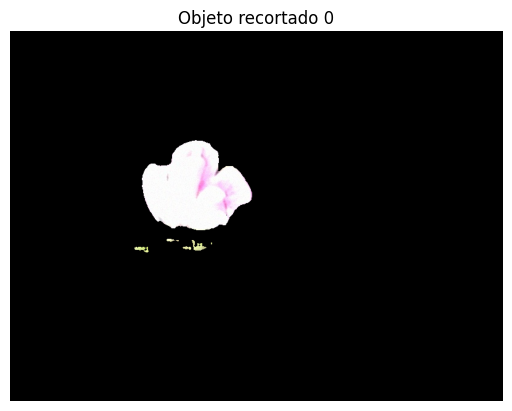

In [ ]:
for i, mask in enumerate(masks):
    binary_mask = mask.squeeze(0).cpu().numpy()
    masked_img = image_rgb.copy()
    masked_img[~binary_mask.astype(bool)] = 0  # Poner fondo en negro

    plt.figure()
    plt.imshow(masked_img)
    plt.title(f"Objeto recortado {i}")
    plt.axis("off")
    plt.show()


In [ ]:
for i, mask in enumerate(masks):
    mask_np = mask.squeeze(0).cpu().numpy()
    y_indices, x_indices = mask_np.nonzero()
    if len(x_indices) > 0 and len(y_indices) > 0:
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        print(f"Máscara {i}: BBox = [{x_min}, {y_min}, {x_max}, {y_max}]")


Máscara 0: BBox = [202, 177, 392, 358]


In [ ]:
for i, mask in enumerate(masks):
    mask_np = (mask.squeeze(0).cpu().numpy() * 255).astype('uint8')
    rgba = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2RGBA)
    rgba[..., 3] = mask_np  # Usar máscara como canal alpha

    output_path = os.path.join(output_mask_dir, f"overlay_{i}.png")
    Image.fromarray(rgba).save(output_path)


In [ ]:
print(image_bgr)

[[[ 61  64  69]
  [ 61  64  69]
  [ 61  64  69]
  ...
  [159 126 111]
  [159 126 111]
  [159 126 111]]

 [[ 61  64  69]
  [ 61  64  69]
  [ 61  64  69]
  ...
  [159 126 111]
  [159 126 111]
  [159 126 111]]

 [[ 61  64  69]
  [ 61  64  69]
  [ 61  64  69]
  ...
  [159 126 111]
  [159 126 111]
  [159 126 111]]

 ...

 [[135 130 129]
  [136 131 130]
  [137 133 132]
  ...
  [192 192 192]
  [192 192 192]
  [192 192 192]]

 [[133 128 127]
  [135 130 129]
  [136 132 131]
  ...
  [192 192 192]
  [192 192 192]
  [192 192 192]]

 [[132 127 126]
  [133 128 127]
  [134 130 129]
  ...
  [192 192 192]
  [192 192 192]
  [192 192 192]]]
